# GNN project - node classifiaction

## EDA

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

In [2]:
NODES  = pd.read_csv('data/SS-Butterfly_labels.tsv', sep='\t')
EDGES  = pd.read_csv('data/SS-Butterfly_weights.tsv', sep='\t')

In [3]:
NODES = NODES.rename(columns={'# Node_ID': 'Node_ID', 'Species': 'species'})
print(NODES.shape)
NODES.head()

(832, 2)


,Node_ID,species
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [4]:
EDGES = EDGES.rename(columns={'# NodeID1': 'NodeID1', 'NodeID2': 'NodeID2', 'Image similarity weight': 'Image similarity weight'})
EDGES.head()

,NodeID1,NodeID2,Image similarity weight
0,0,4,0.029663
1,0,5,0.250146
2,0,7,0.052237
3,0,10,0.096204
4,0,12,0.102050


In [5]:
G = nx.from_pandas_edgelist(EDGES, 'NodeID1', 'NodeID2')

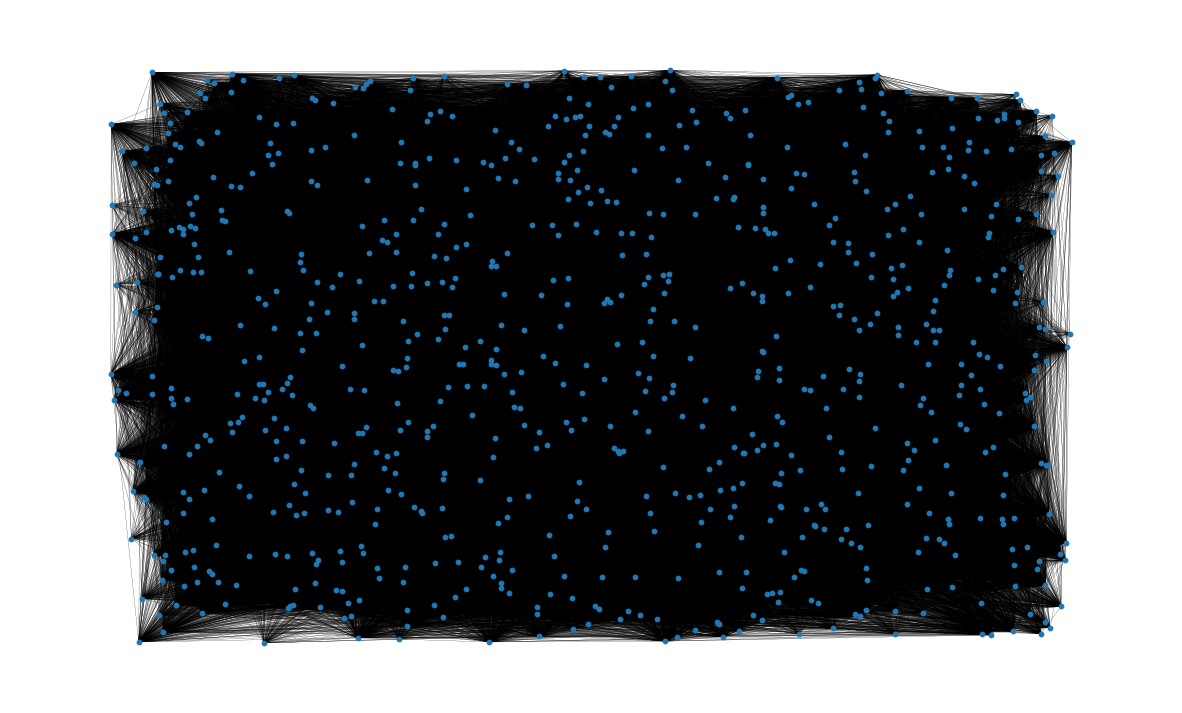

In [6]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

In [7]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Mean degree of nodes:", np.mean([d for _, d in G.degree()]))


Number of nodes: 832
Number of edges: 86528
Mean degree of nodes: 208.0


In [8]:
print("Target classes:", NODES["species"].unique())

Target classes: [ 1  2  3  4  5  6  7  8  9 10]


## GNN model for node classifiaction

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

# Create a custom GNN model
class GNNNodeClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [38]:
# Prepare the data
nodes = NODES['Node_ID'].values
labels = NODES['species'].values
edges = EDGES[['NodeID1', 'NodeID2']].values.transpose()
weights = EDGES['Image similarity weight'].values

x = torch.tensor(nodes, dtype=torch.float).view(-1, 1)  # Node features
y = torch.tensor(labels, dtype=torch.long)  # Node labels
edge_index = torch.tensor(edges, dtype=torch.long)  # Edge indices
edge_weight = torch.tensor(weights, dtype=torch.float)  # Edge weights

data = Data(x=x, edge_index=edge_index, y=y, edge_weight=edge_weight)


In [39]:
# Define model parameters
num_features = 1  # Number of node features (in this case, just 'Node_ID')
num_classes = torch.unique(y).size(0)  # Number of unique classes

# Create the GNN model
model = GNNNodeClassifier(num_features, num_classes)

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Train the model
model.train()


GNNNodeClassifier(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 10)
)

In [40]:
train_size = int(832*0.7)

# Indices of nodes in the training set
a = np.arange(832)
np.random.shuffle(a)
train_indices = a[:train_size]
train_indices.sort()
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
data.train_mask = train_mask

# Indices of nodes in the testing set
test_mask = [not x for x in train_mask]
test_mask = torch.tensor(test_mask)
data.test_mask = test_mask


In [41]:
# # check
# print(sum(train_mask))
# print(sum(test_mask))
# print(sum(train_mask) + sum(test_mask))


tensor(582)
tensor(250)
tensor(832)


In [42]:
losses = []

for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data)

    predictions = out
    targets = data.y - 1

    loss = criterion(predictions[data.train_mask], targets[data.train_mask])
    loss.backward()
    optimizer.step()

    losses += [loss.item()]
    if epoch%100==1:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


Epoch: 2, Loss: 48.56406021118164
Epoch: 102, Loss: 4.170915603637695
Epoch: 202, Loss: 1.7472424507141113
Epoch: 302, Loss: 1.6413969993591309
Epoch: 402, Loss: 1.561251163482666
Epoch: 502, Loss: 10.944432258605957
Epoch: 602, Loss: 1.436740756034851
Epoch: 702, Loss: 1.3912220001220703
Epoch: 802, Loss: 1.3531876802444458
Epoch: 902, Loss: 1.3177441358566284


Convergence of the loss function for each epoch

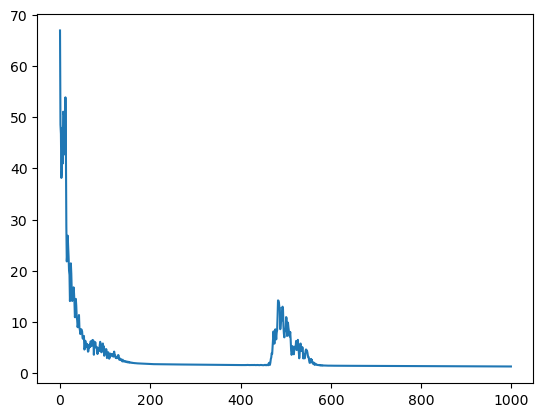

In [43]:
plt.plot(losses)
plt.show()

Predicted values vs. target

In [44]:
pred = model(data).argmax(dim=1)
print(*[(a,b) for (a,b) in zip(pred, targets)], sep='\n')

(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0), tensor(0))
(tensor(0),

Accuracy score

In [45]:
# Evaluate the model
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim=1)
    correct = pred[data.test_mask] == targets[data.test_mask]
    accuracy = int(correct.sum()) / int(data.test_mask.sum())
    print(f"Accuracy: {accuracy}")


Accuracy: 0.48
